*Copyright (C) 2021 Intel Corporation*<br>
*SPDX-License-Identifier: BSD-3-Clause*<br>
*See: https://spdx.org/licenses/*

# Solving Quadratic Programs with PIPGeq 

In this notebook, we explore how Quadratic Programs can be solved using PIPGeq (https://ieeexplore.ieee.org/document/9295329), an algorithm to solve equality constrained Quadratic Programs with quadratic convergence for solution and cubic convergence for constraint satisfaction for strongly convex cases. It has been designed keeping edge-level MPC in mind.  

### Recommended Tutorials before starting

- [Installing Lava](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial01_installing_lava.ipynb)
- [Processes](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial02_processes.ipynb "Tutorial on Processes")
- [ProcessModel](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial03_process_models.ipynb "Tutorial on ProcessModels")
- [Execution](https://github.com/lava-nc/lava/blob/main/tutorials/in_depth/tutorial04_execution.ipynb "Tutorial on Executing Processes")
- [Quadratic Programming in Lava](https://github.com/lava-nc/lava-optimization/blob/main/tutorials/tutorial_01_solving_lasso.ipynb)

### PIPG to solve QPs on Loihi

Consider a QP of the following form:
$$ \text{argmin} \frac{1}{2}x^TQx + p^Tx $$
$$ \text{s.t.  } Ax = k,$$
$$ l \le x \le u $$
where $ x \in \mathbb{R}^n$, $ Q \in \mathbb{S}_{+}^{n \times n}$, $ p \in \mathbb{R}^n$ , $ A \in \mathbb{R}^{m \times n} $ and $ k \in \mathbb{R}^m$ where $m$ and $n$ are integers. $l$ and $u$ are lower and upper bounds on the variable x. This can be solved with the following first-order iterative update scheme,

$$ v_j = w_j + \beta_j \cdot (Ax_j - k) $$
$$ x_{j+1} = \pi_{X}(x_j - \alpha_j \cdot (Qx_j + p + A^Tv_j)) $$
$$ w_{j+1} = w_j + \beta_j \cdot (Ax_{j+1} - k) $$

The learning rates are given by:
$$ \alpha_k = \frac{2}{(k+1)\cdot\mu + 2\lambda} \text{ and } \beta_k = \frac{(k+1)\cdot\mu}{2\sigma}$$
where $ \mu I \le Q \le \lambda I$ and $ A^TA \le \sigma I$
The above equations can be reduced to the following process models in Lava 

we assume no bounds on the variable $x$ and therefore in the above equations, $\pi_X(x) = \text{min}(\text{max}(x, - \infty), \infty) = x$

### Reference Solution

In [1]:
import numpy as np
from scipy.spatial import distance
from scipy import sparse
import matplotlib.pyplot as plt
import time

In [2]:
a = np.load('qp/data/anymal_full_scale/mpc_4800_2000.npz')
Q, A, p, k = [a[i] for i in a] 

In [3]:
Q.shape, A.shape, p.shape, k.shape

((4824, 4824), (2424, 4824), (4824, 1), (2424, 1))

In [4]:
import osqp

Q_ref = sparse.csc_matrix(Q)

A_ref = sparse.csc_matrix(A)

l_eq = k
u_eq = k

#create OSQP object
prob = osqp.OSQP()

prob.setup(Q_ref, p, A_ref, l_eq, u_eq, warm_start=False)

res = prob.solve()

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 4824, constraints m = 2424
          nnz(P) + nnz(A) = 27002
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.2357e+08   2.30e-02   2.44e+02   1.00e-01   7.84e-03s
  25  -1.7027e+08   2.03e-06   1.11e-02   1.00e-01   1.25e-02s

status:               solved
number of 

In [5]:
ref_sol_osqp = res.x.reshape((res.x.shape[0], 1)).copy()
opt_objective =  res.info.obj_val

### Preconditioning the Problem 

We use the ruiz equilibriation class of preconditioners which are a cheap class of diagonal preconditioners that can speed-up the convergence of first-order methods like PIPG to solve QPs. The preconditioner we use is defined below.

In [6]:
def ruiz_equilibriation(matrix, iterations):
    #tic = time.time()
    m_bar = matrix 
    left_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[0]))
    right_preconditioner = sparse.csc_matrix(np.eye(matrix.shape[1]))
    row_del, col_del = 0, 0
    for i in range(iterations):
        D_l_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=1))))
        if(m_bar.shape[0] != m_bar.shape[1]):
            D_r_inv = sparse.csc_matrix(np.diag(1/np.sqrt(np.linalg.norm(m_bar, ord=2, axis=0))))
        else:
            D_r_inv = D_l_inv
            
        m_bar = D_l_inv@m_bar@D_r_inv
        left_preconditioner = left_preconditioner@D_l_inv
        #right_preconditioner = right_preconditioner@D_r_inv
        row_del = np.max(np.abs(1-np.linalg.norm(m_bar, ord=2, axis=1))) 
    print(row_del)
    #print(time.time()-tic)
    return left_preconditioner, right_preconditioner

In [7]:
pre_mat_Q, _ = ruiz_equilibriation(Q, 5)
Q_pre = pre_mat_Q@Q@pre_mat_Q
p_pre = pre_mat_Q@p

pre_mat_A, _ = ruiz_equilibriation(A, 5)
A_pre = pre_mat_A@A@pre_mat_Q
k_pre = pre_mat_A@k

0.0038963844132905434
0.6353366351851955


### Solver Learning Learning rates 

We have empirically determined these values of solver learning rates parameters to work for our problem

In [66]:
mu, sigma, lamda =  0.11, 8.14, 1.6

We have alpha and beta given for the algorithms as follows 

In [67]:
def alpha_pipg(k):
    return 2/((k+1)*mu + 2*lamda)

def beta_pipg(k):
    return (k+1)*mu/(2*sigma)

In [68]:
alpha_l, beta_l  = [], []
for i in range(1000):
    alpha_l.append(alpha_pipg(i))
    beta_l.append(beta_pipg(i))

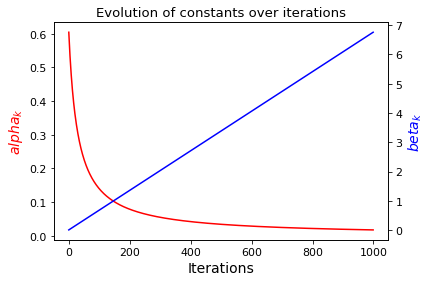

In [69]:
fig,ax = plt.subplots()
plt.title("Evolution of constants over iterations")
ax.plot(alpha_l, color="red")
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$alpha_k$",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_l,color="blue")
ax2.set_ylabel("$beta_k$",color="blue",fontsize=14)
plt.show()

For Lava, the evolution of alpha and beta cannot has to be controlled by right (decrease) and left shifts (increase). Keeping this in mind we inspect the above graph and choose the following decay indices.

In [70]:
alpha_decay_indices_list = [35, 100, 200, 350, 600, 900]
beta_growth_indices_list = [1, 3, 7, 15, 31, 63, 127, 255, 511, 900]

In [71]:
alpha_lava_l , beta_lava_l = [], []
alpha_lava, beta_lava = alpha_pipg(0), beta_pipg(0)
alpha_lava_l.append(alpha_lava)
beta_lava_l.append(beta_lava)
for i in range(1000):
    if (i in alpha_decay_indices_list):
        alpha_lava/=2
    if (i in beta_growth_indices_list):
        beta_lava*=2
        
    alpha_lava_l.append(alpha_lava)
    beta_lava_l.append(beta_lava)
   

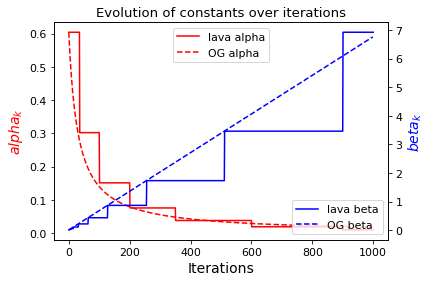

In [72]:
fig,ax = plt.subplots()
plt.title("Evolution of constants over iterations")
ax.plot(alpha_lava_l, color="red", label='lava alpha')
ax.plot(alpha_l,'--', color="red", label='OG alpha')
ax.set_xlabel("Iterations",fontsize=14)
ax.set_ylabel("$alpha_k$",color="red",fontsize=14)
ax2=ax.twinx()
ax2.plot(beta_lava_l,color="blue", label='lava beta')
ax2.plot(beta_l,'--', color="blue", label='OG beta')
ax2.set_ylabel("$beta_k$",color="blue",fontsize=14)
ax.legend(loc='upper center')
ax2.legend(loc='lower right')
plt.show()

### Lava PIPG solver

Now we put things together and run the PIPG solver in Lava

In [73]:
from lava.magma.core.run_conditions import RunSteps
from lava.magma.core.run_configs import Loihi1SimCfg
from lava.lib.optimization.solvers.qp.models import (
    ConstraintDirections,
    ConstraintNormals,
    QuadraticConnectivity,
    ProjectedGradientNeuronsPIPGeq,
    ProportionalIntegralNeuronsPIPGeq,
    SigmaNeurons,
    DeltaNeurons
)

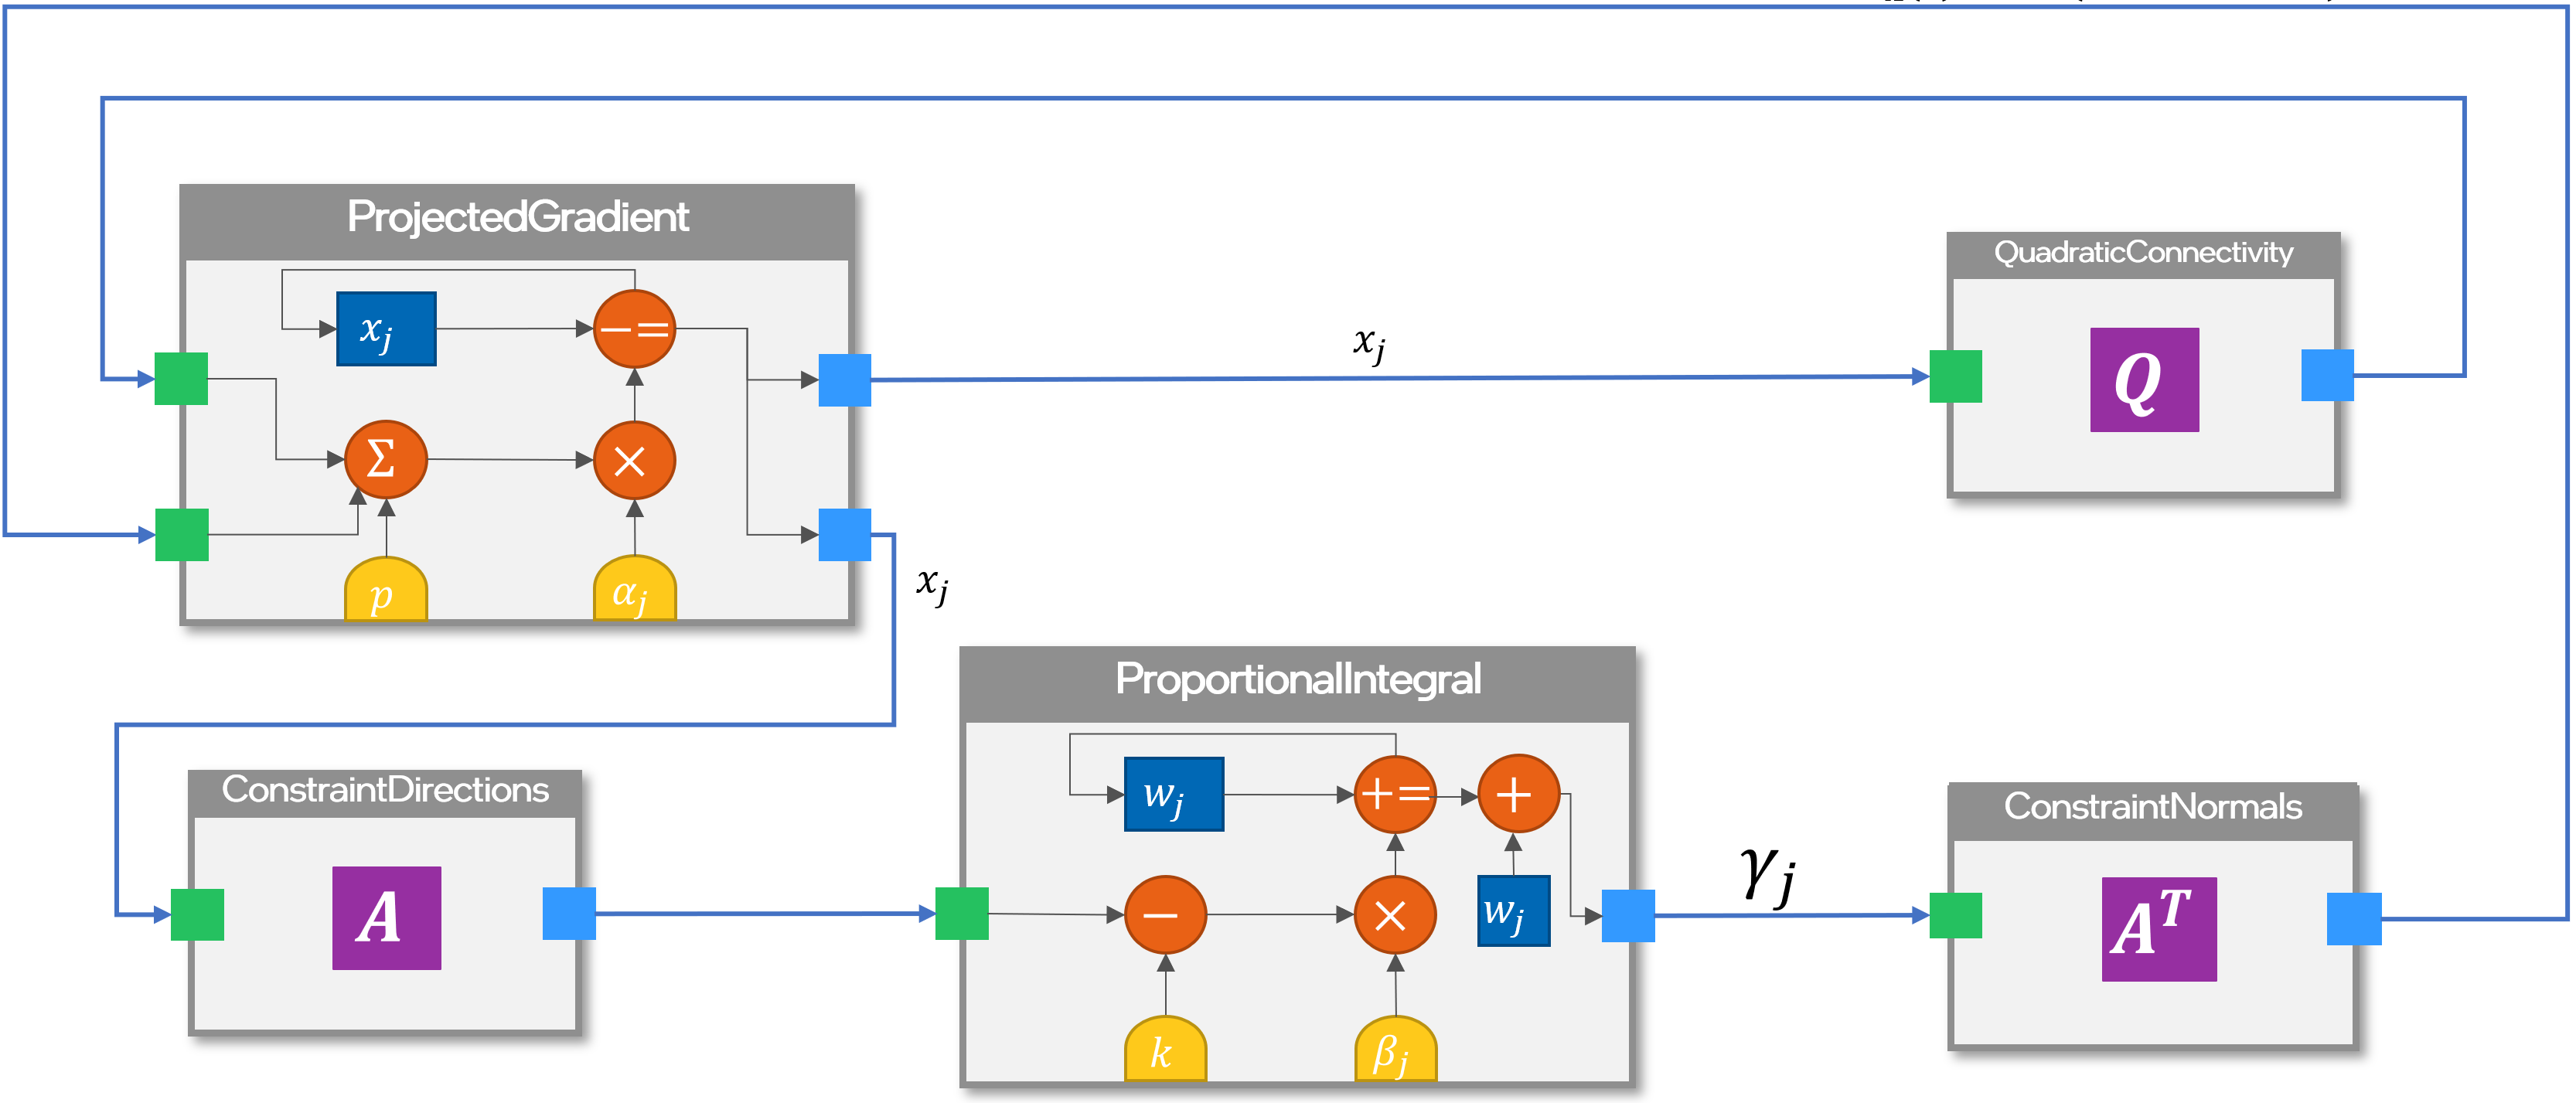

In [74]:
iterations = 300

In [75]:
np.random.seed(10)
# Lava process Initalization for PIPGeq
# Neuron Processes
ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                           qp_neurons_init=np.random.rand(p_pre.shape[0], 1),
                                           grad_bias=p_pre,
                                           alpha=alpha_pipg(0),
                                           lr_decay_type = 'indices',
                                           alpha_decay_indices = alpha_decay_indices_list)

ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                           constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                           thresholds=k_pre,
                                           beta=beta_pipg(0),
                                           lr_growth_type = 'indices',
                                           beta_growth_indices = beta_growth_indices_list 
                                           )

# Connection Processes
ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)

# Connecting Processes together
QuadConn.a_out.connect(ProjGrad.a_in_qc)
ConsNorm.a_out.connect(ProjGrad.a_in_cn)
ProjGrad.s_out_qc.connect(QuadConn.s_in)
ProjGrad.s_out_cd.connect(ConsDir.s_in)
ConsDir.a_out.connect(ProInt.a_in)
ProInt.s_out.connect(ConsNorm.s_in)

# Run solver dynamics QP
toc = time.time()
ProjGrad.run(condition=RunSteps(num_steps=iterations),
                      run_cfg=Loihi1SimCfg()
                     )

# get pre-conditioned solution 
pre_sol_k = ProjGrad.vars.qp_neuron_state.get()

# Profiling data
tot_synops = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
tot_spikeops = ProInt.vars.spikeops.get() + ProjGrad.vars.spikeops.get() 

# stop process execution
ProjGrad.stop()

tic = time.time()
print("Solution in {} seconds".format(tic-toc))

# postconditioning to get actual solution
sol_k =  pre_mat_Q@pre_sol_k

Solution in 16.418830156326294 seconds


In [76]:
print("The constraint violation residual is {}".format(np.linalg.norm(A@sol_k-k)))

The constraint violation residual is 12.464827241483905


In [77]:
print("Solution Percentage error is {}".format(np.linalg.norm(ref_sol_osqp - sol_k)/np.linalg.norm(ref_sol_osqp)*100))

Solution Percentage error is 0.22556012739735065


### Solver Sparsification

We use Sigma-Delta coding to sparsify the output activity of neurons. First we start with a reference problem  

In [78]:
print("For reference, number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format( 
                                                                                     tot_synops/iterations, tot_spikeops/iterations))
ref_grad = -(Q_pre@pre_sol_k + p_pre) 
ref_sol = (pre_mat_Q@pre_sol_k).copy()
ref_synops = tot_synops.copy()

For reference, number of operations per iteration 
 Syn Ops: [[49180.]] 
 Spike Ops: [[7248.]]



Next we use a sparsification schedule that uses a constant value of theta, i.e the delta spiking threshold for the problem remains constant

In [79]:
thetas = [0, 0.001, 0.01, 0.2, 0.5]
accuracies_ct = []
relative_ops_ct = []
grad_sim_ct = []

np.random.seed(10)
qp_init = np.random.rand(p_pre.shape[0], 1)

for theta in thetas:
    ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                           qp_neurons_init=qp_init,
                                           grad_bias=p_pre,
                                           alpha=alpha_pipg(0),
                                           lr_decay_type = 'indices',
                                           alpha_decay_indices = alpha_decay_indices_list)

    ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                               constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                               thresholds=k_pre,
                                               beta=beta_pipg(0),
                                               lr_growth_type = 'indices',
                                               beta_growth_indices = beta_growth_indices_list 
                                               )
        
    # Connection Processes
    ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
    ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
    QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)
    
    # Delta Neuron process, same initial value as qp_init
    # theta_decay_schedule set to 10000 to maintain constant theta till 10000 iterations
    delNeur = DeltaNeurons(shape=qp_init.shape,
                           x_del_init=qp_init,
                           theta=theta,
                           theta_decay_schedule=10000,
                            )
    

    
    # Connecting Processes together, adding sparsifying processes in between
    QuadConn.a_out.connect(ProjGrad.a_in_qc)
    ConsNorm.a_out.connect(ProjGrad.a_in_cn)
    
    ProjGrad.s_out_qc.connect(delNeur.s_in)
    delNeur.s_out.connect(QuadConn.s_in)

    
    delNeur.s_out.connect(ConsDir.s_in)
    ConsDir.a_out.connect(ProInt.a_in)
    ProInt.s_out.connect(ConsNorm.s_in)
    


    # Run solver dynamics QP
    toc = time.time()
    ProjGrad.run(condition=RunSteps(num_steps=iterations),
                          run_cfg=Loihi1SimCfg()
                         )

    # get pre-conditioned solution 
    pre_sol_k_ct = ProjGrad.vars.qp_neuron_state.get()
   
    # Profiling data for constant theta
    tot_synops_ct = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
    tot_spikeops_ct = ProInt.vars.spikeops.get() + delNeur.vars.spikeops.get() 

    # stop process execution
    ProjGrad.stop()
    
    grad_ct = -(Q_pre@pre_sol_k_ct + p_pre) 
    print("Finished calcuations for constant theta={} in {} seconds".format(theta, time.time()-toc))

    # Append stats for constant theta to a list
    grad_sim_ct.append(distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_ct.reshape(grad_ct.shape[0],)))
    accuracies_ct.append(np.linalg.norm(ref_sol - (pre_mat_Q@pre_sol_k_ct))/np.linalg.norm(ref_sol)*100)
    relative_ops_ct.append((ref_synops/tot_synops_ct).squeeze(axis=0))
    print("For constant theta={} number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format(theta, 
                                                                                     tot_synops_ct/iterations, tot_spikeops_ct/iterations))
    

Finished calcuations for constant theta=0 in 17.60650086402893 seconds
For constant theta=0 number of operations per iteration 
 Syn Ops: [[49180.]] 
 Spike Ops: [[7248.]]

Finished calcuations for constant theta=0.001 in 16.23316740989685 seconds
For constant theta=0.001 number of operations per iteration 
 Syn Ops: [[47381.57333333]] 
 Spike Ops: [[6987.90666667]]

Finished calcuations for constant theta=0.01 in 15.80301833152771 seconds
For constant theta=0.01 number of operations per iteration 
 Syn Ops: [[43962.09]] 
 Spike Ops: [[6498.87]]

Finished calcuations for constant theta=0.2 in 16.804054498672485 seconds
For constant theta=0.2 number of operations per iteration 
 Syn Ops: [[35783.38]] 
 Spike Ops: [[5322.22]]

Finished calcuations for constant theta=0.5 in 17.039701223373413 seconds
For constant theta=0.5 number of operations per iteration 
 Syn Ops: [[33000.20333333]] 
 Spike Ops: [[4949.56333333]]



In [80]:
# postconditioning to get actual solution
sol_k =  pre_mat_Q@pre_sol_k_ct
print("Solution Percentage error is {}".format(np.linalg.norm(ref_sol_osqp - sol_k)/np.linalg.norm(ref_sol_osqp)*100))

Solution Percentage error is 3.359715963247626


We now use adaptive theta to vary the thresholding as the number of iterations increase

In [81]:
thetas = [0, 0.001, 0.01, 0.2, 0.5, 1, 2, 10, 20]
#thetas = [0, 10, 15, 20, 25, 50]
#thetas = [10]
accuracies_at = []
relative_ops_at = []
grad_sim_at = []


np.random.seed(10)
qp_init = np.random.rand(p_pre.shape[0], 1)

for theta in thetas:
    ProjGrad = ProjectedGradientNeuronsPIPGeq(shape=p_pre.shape, 
                                           qp_neurons_init=qp_init,
                                           grad_bias=p_pre,
                                           alpha=alpha_pipg(0),
                                           lr_decay_type = 'indices',
                                           alpha_decay_indices = alpha_decay_indices_list)

    ProInt = ProportionalIntegralNeuronsPIPGeq(shape=k_pre.shape, 
                                               constraint_neurons_init=np.random.rand(k_pre.shape[0], 1),
                                               thresholds=k_pre,
                                               beta=beta_pipg(0),
                                               lr_growth_type = 'indices',
                                               beta_growth_indices = beta_growth_indices_list 
                                               )
        
    # Connection Processes
    ConsDir = ConstraintDirections(shape=A_pre.shape, constraint_directions=A_pre)
    ConsNorm = ConstraintNormals(shape=A_pre.T.shape, constraint_normals=A_pre.T)
    QuadConn = QuadraticConnectivity(shape=Q_pre.shape, hessian=Q_pre)
    
    # Delta Neuron process, same initial value as qp_init
    # theta_decay_schedule set to 50 
#     delNeur = DeltaNeurons(shape=qp_init.shape,
#                            x_del_init=qp_init,
#                            theta=theta,
#                            theta_decay_type = 'indices',
#                            theta_decay_indices = alpha_decay_indices_list
#                             )
    delNeur = DeltaNeurons(shape=qp_init.shape,
                       x_del_init=qp_init,
                       theta=theta,
                       theta_decay_schedule = 60
                        )

    
    # Connecting Processes together, adding sparsifying processes in between
    QuadConn.a_out.connect(ProjGrad.a_in_qc)
    ConsNorm.a_out.connect(ProjGrad.a_in_cn)
    
    ProjGrad.s_out_qc.connect(delNeur.s_in)
    delNeur.s_out.connect(QuadConn.s_in)

    
    delNeur.s_out.connect(ConsDir.s_in)
    ConsDir.a_out.connect(ProInt.a_in)
    ProInt.s_out.connect(ConsNorm.s_in)
    

    # Run solver dynamics QP
    toc = time.time()
    ProjGrad.run(condition=RunSteps(num_steps=iterations),
                          run_cfg=Loihi1SimCfg()
                         )

    # get pre-conditioned solution 
    pre_sol_k_at = ProjGrad.vars.qp_neuron_state.get()
   
    # Profiling data for constant theta
    tot_synops_at = QuadConn.vars.synops.get() + ConsNorm.vars.synops.get() + ConsDir.vars.synops.get()
    tot_spikeops_at = ProInt.vars.spikeops.get() + delNeur.vars.spikeops.get() 

    # stop process execution
    ProjGrad.stop()
    
    grad_at = -(Q_pre@pre_sol_k_at + p_pre) 
    print("Finished calcuations for adaptive theta={} in {} seconds".format(theta, time.time()-toc))

    # Append stats for constant theta to a list
    grad_sim_at.append(distance.cosine(ref_grad.reshape(ref_grad.shape[0],), grad_at.reshape(grad_at.shape[0],)))
    accuracies_at.append(np.linalg.norm(ref_sol - (pre_mat_Q@pre_sol_k_at))/np.linalg.norm(ref_sol)*100)
    relative_ops_at.append((ref_synops/tot_synops_at).squeeze(axis=0))
    print("For adaptive theta={} number of operations per iteration \n Syn Ops: {} \n Spike Ops: {}\n".format(theta, 
                                                                                     tot_synops_at/iterations, tot_spikeops_at/iterations))
    

Finished calcuations for adaptive theta=0 in 16.180504083633423 seconds
For adaptive theta=0 number of operations per iteration 
 Syn Ops: [[49180.]] 
 Spike Ops: [[7248.]]

Finished calcuations for adaptive theta=0.001 in 18.868936777114868 seconds
For adaptive theta=0.001 number of operations per iteration 
 Syn Ops: [[48234.91333333]] 
 Spike Ops: [[7111.11]]

Finished calcuations for adaptive theta=0.01 in 20.453989028930664 seconds
For adaptive theta=0.01 number of operations per iteration 
 Syn Ops: [[46422.56666667]] 
 Spike Ops: [[6838.85666667]]

Finished calcuations for adaptive theta=0.2 in 21.761083364486694 seconds
For adaptive theta=0.2 number of operations per iteration 
 Syn Ops: [[40327.58]] 
 Spike Ops: [[6003.92]]

Finished calcuations for adaptive theta=0.5 in 16.639057874679565 seconds
For adaptive theta=0.5 number of operations per iteration 
 Syn Ops: [[37916.70666667]] 
 Spike Ops: [[5656.19333333]]

Finished calcuations for adaptive theta=1 in 15.56348943710327

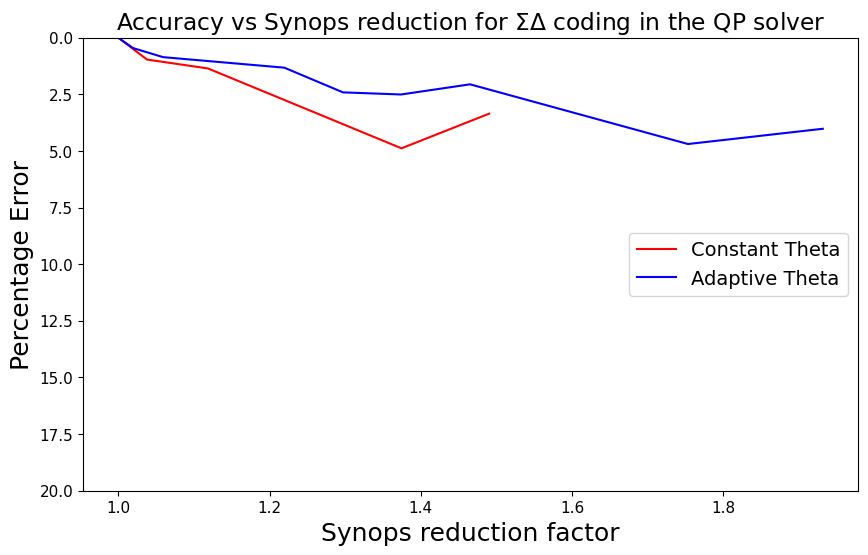

In [82]:
fig,ax = plt.subplots(figsize=(10, 6), dpi=100)
plt.rcParams.update({'font.size': 14})
plt.title("Accuracy vs Synops reduction for $ \Sigma \Delta $ coding in the QP solver")
ax.plot(relative_ops_ct, accuracies_ct, color="red", label='Constant Theta')
ax.set_ylabel("Percentage Error",color="black",fontsize=18)
ax.invert_yaxis()
ax.set_ylim(20,0)
ax.plot(relative_ops_at, accuracies_at, color="blue", label='Adaptive Theta')
ax.set_xlabel("Synops reduction factor",fontsize=18)
ax.legend(loc="center right")
plt.show()

In [83]:
accuracies_ct, accuracies_at

([0.0,
  0.9623680144291028,
  1.3578322284105124,
  4.88230294789274,
  3.3519892272980663],
 [0.0,
  0.45756870986320847,
  0.858284167707667,
  1.322085077420729,
  2.4123687778311345,
  2.5063702123073672,
  2.057309517518828,
  4.693403267645843,
  4.0195471295731195])

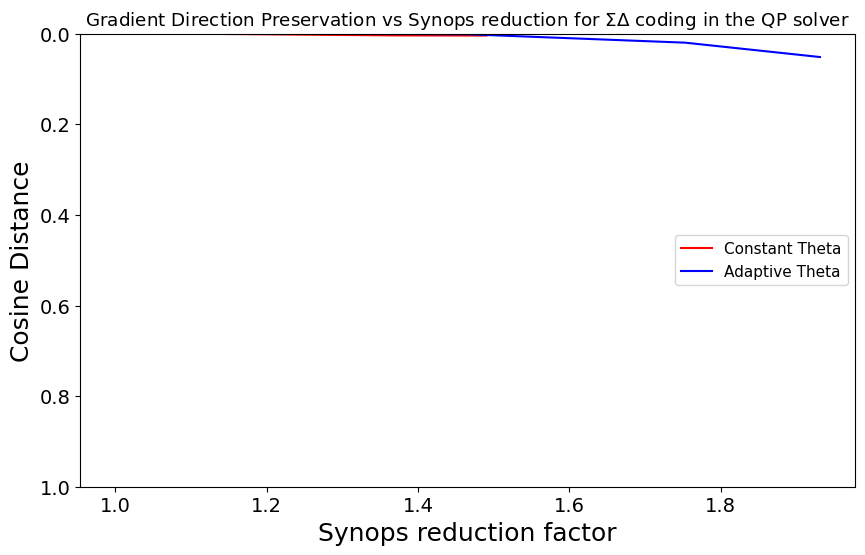

In [84]:
fig,ax = plt.subplots(figsize=(10, 6), dpi=100)
plt.rcParams.update({'font.size': 11})
plt.title("Gradient Direction Preservation vs Synops reduction for $ \Sigma \Delta $ coding in the QP solver")
ax.plot(relative_ops_ct, grad_sim_ct, color="red", label='Constant Theta')
ax.set_ylabel("Cosine Distance",color="black",fontsize=18)
ax.invert_yaxis()
ax.set_ylim(1, 0)
ax.plot(relative_ops_at, grad_sim_at, color="blue", label='Adaptive Theta')
ax.set_xlabel("Synops reduction factor",fontsize=18)
ax.legend(loc="center right")
plt.show()

### Fixed Point Conversion

An added advantage of pre-conditioning apart from making the first-order method faster is to reduce the dynamic range of the system. This can aid the fixed-point conversion process. 

In [38]:
Q.shape

(4824, 4824)

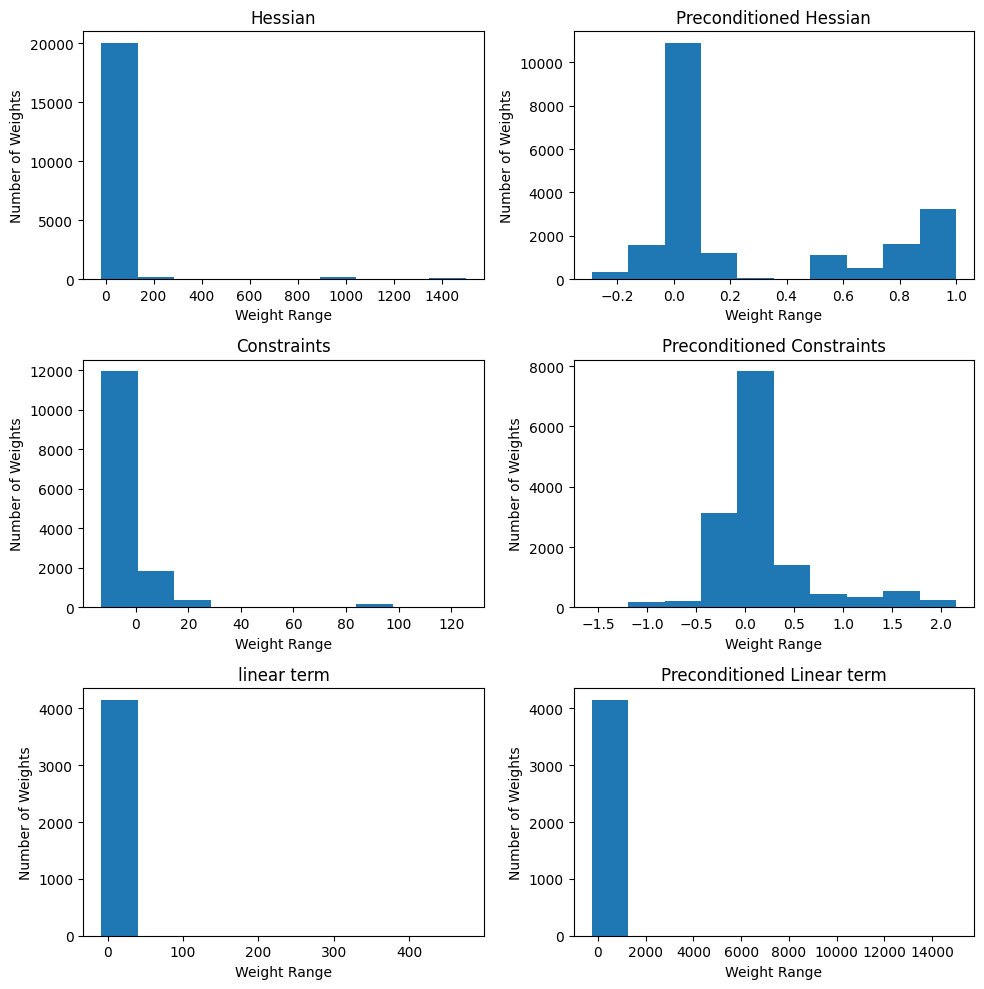

In [66]:
Q_non_zero = Q[np.abs(Q)>0]
A_non_zero = A[np.abs(A)>0]
p_non_zero = p[np.abs(p)>0]

Q_pre_non_zero = Q_pre[np.abs(Q_pre)>0]
A_pre_non_zero = A_pre[np.abs(A_pre)>0]
p_pre_non_zero = p_pre[np.abs(p_pre)>0]

xaxes = 'Weight Range'
yaxes = 'Number of Weights'
titles = ['Hessian','Preconditioned Hessian','Constraints','Preconditioned Constraints', 'linear term', 'Preconditioned Linear term'] 

f,a = plt.subplots(3,2, figsize=(10, 10), dpi=100)
#plt.xscale('log')

a = a.ravel()
data=[Q_non_zero,Q_pre_non_zero, A_non_zero, A_pre_non_zero, p_non_zero, p_pre_non_zero]

bins = [2**x for x in range(-13,12)]
for idx,ax in enumerate(a):
    ax.hist(data[idx])
    ax.set_title(titles[idx])
    ax.set_xlabel(xaxes)
    ax.set_ylabel(yaxes)

plt.tight_layout()

# axs[0, 0].hist(Q_pre_non_zero, bins=bins)

# plt.xscale('log')
# plt.title("Weight Histogram for Q_pre matrix") 
# plt.show()
# print("Histogram values: {}".format(n))

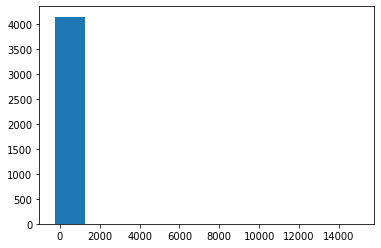

In [62]:
n = plt.hist(data[5], bins=10)

In [63]:
n[0], n[1] # y, x

(array([4.153e+03, 3.000e+00, 3.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([ -259.94806835,  1266.64553737,  2793.23914309,  4319.83274881,
         5846.42635453,  7373.01996025,  8899.61356598, 10426.2071717 ,
        11952.80077742, 13479.39438314, 15005.98798886]))

### How to learn more?

Watch this [space](https://github.com/lava-nc/lava-optimization) to learn about upcoming developments to the QP solver and the optimization toolbox in Lava in general. 

If you want to find out more about the implementation of the QP solver, have a look at the [Lava documentation](https://lava-nc.org/ "Lava Documentation") or dive into the [source code](https://github.com/lava-nc/lava-optimization/tree/main/src/lava/lib/optimization/solvers/qp
"QP source code").
To receive regular updates on the latest developments and releases of the Lava Software Framework please subscribe to the [INRC newsletter](http://eepurl.com/hJCyhb "INRC Newsletter").